## Transporation mode choice modeling

Transportation planning and assessments are important aspects of modeling urban systems and are critical in making key decisions and shaping/estimating the commute behavior of urban populace. Some of the key impact assessments from the model could be evaluating change in net commute time savings, change in pollution emissions, traffic volumes etc. across an urban area of interest.

Here we demonstrate a framework for transporation mode choice modeling using Bayesian inference. Essentially, we want to model ridership across multiple modes by estimating mode choice between origin-destination taxi zone pairs in New York City among 4 available mode choices - transit, taxi, walking and driving. 

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.5
!pip install Theano==1.0.4

In [187]:
import pandas as pd
import numpy as np
from numpy import inf
import seaborn as sns
from scipy.stats import norm
import itertools
import theano
from theano import tensor as tt
import pymc3 as pm
import arviz
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

We use data from primarily two sources: 
- the travel duration and fare cost for taxi, transit and driving modes are extracted from Google Maps API for each of the origin-destination taxi zone pairs. Cost for walking is kept as 0.
- the mobility information and aggregated income information is retrieved from LEHD data along with ACS for origin-destination commute choice information, further aggregated on taxi zone levels.


The combined data thus contains travel time, travel cost and aggregated commuter information corresponding to each of O-D pairs and 4 travel modes.

The travel modes (column 'tmode') contains codes for each mode referenced as- 2: transit, 3: taxi, 5: walking, 8: driving


In [3]:
# read the data

data = pd.read_csv('LEHD_commute.csv')
data['duration'] = data['duration']/60  # convert time to hours
data['ridership'] = data.iloc[:, 5:].sum(axis=1)  ## aggregate the ridership across income groups
data = data[['pulocationid', 'dolocationid', 'tmode', 'duration', 'price', 'ridership']]
data.head()

pulocationid  dolocationid  tmode  duration      price  ridership
0             3             7      8  0.653356  12.721600        736
1             3             7      3  0.798016  43.157143          0
2             3            18      3  0.254000  12.900000       1748
3             3            18      5  1.084444   0.000000       3174
4             3            18      8  0.268923   7.432000      10879

In [4]:
data.ridership.sum()

191552556

In [5]:
# number of unique O-D pairs

len(data[['pulocationid', 'dolocationid']].drop_duplicates())

19152

In [6]:
# unique modes

data.tmode.unique()

array([8, 3, 5, 2])

([<matplotlib.axis.XTick at 0x7fa482ddda10>,
 [Text(0, 0, 'Transit'),
  Text(0, 0, 'Taxi'),
  Text(0, 0, 'Walking'),
  Text(0, 0, 'Driving')])

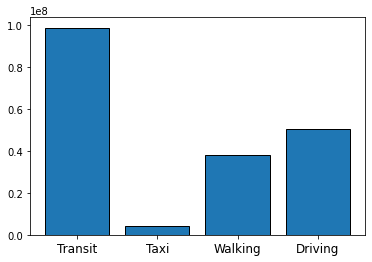

In [7]:
## ridership by mode
byMode = data.groupby(by='tmode', as_index=False).sum()[['tmode', 'ridership']]
plt.bar(np.arange(len(byMode)), list(byMode.ridership), edgecolor = 'black')
plt.xticks([r  for r in range(len(byMode))], ['Transit', 'Taxi',
                                                      'Walking', 'Driving'], fontsize=12)

We use the Multinomial Logit (MNL) as the modeling framework for estimating the mode choice probabilities. MNL is broadly used in transportation choice modeling. It offers an advantage of estimating the mode-choice probabilities using closed-form formulas representing the aggregate-level choices.

the probabilities for each of the four major transportation modes to be chosen as having the highest utility is defined as
$$
\begin{equation}
    P_{mode} = \frac{e^{\lambda U_{mode}}}{e^{\lambda U_{taxi}} + e^{\lambda U_{transit}} + e^{\lambda U_{walk}} + e^{\lambda U_{drive}}}
\end{equation}
$$

$\lambda$ being subject to fit.

Additionally, we define the utilily below.

Mathematically, the utility score $U_j$ for alternative ${j}$ depends on the time taken $T_j$ between the O-D pair in consideration and the monetary cost $P_j$ for choosing the alternative, and a random component of error $\epsilon_j$ , yielding a base utility function
$$
\begin{equation}
    U_j = -(CT_j + P_j)
\end{equation}$$

where C is kept as a constant.

The utility can be interpreted as perceived total 'value' of commuting between a o-d pair by the commuter, incorporating possible irrationality of individual decisions while combining it with the direct monetary cost to assess the overall utility. An additional random error term $\epsilon$ can be added to the utility term following a particular distribution. This could be either an additive term or multiplicative term based on our preferences.
Here we will proceed with the additive case, so the utility being defined as $\begin{equation}
    U_j = -(CT_j + P_j) + \epsilon
\end{equation}$


#### Likelihood estimation

From the estimated probabilities $P_m$, we compute the likelihood of the observed LEHD data give the model for each set of $\beta, \sigma$ parameters. For mode choice probabilities $P_m(o,d,\sigma,\beta)$ for each set of origin(o) and destination(d), the log-likelihood for four modes given the observed LEHD ridership $R_m(o,d)$ is calculated as
$$
\begin{equation}
    L(\sigma, \beta) = \sum_{o,d}\sum_m R_m(o,d)\ln P_m(o,d,\sigma,\beta)
\end{equation}
$$


One can simulate the results just for the max-likelihood parameters, however comprehensive parameter sampling provides assessment with respect to the model uncertainty.



In [8]:
# choice for constant C - put as median hourly NYC income
# NYC median income is ~ $33,220 per year

C = 33220/(12*30*24)
C

3.8449074074074074

As defined in the utility function, the coefficient C can be interpreted as a parameter incorporating irrationality of decisions based on time and cost. 

We use the total number of hours in a day instead of number of working hours to assess the cost of time as people often underestimate the value of time.  So we try a lower bound value (which apparently also provides a better fit to the data). It could be a good idea to fit C as another parameter of the model, but we keep it fixed to make fitting easier for the illustration purposes.

Modeling:  We'll use Bayesian inference for fitting the model. There is just one parameter $\lambda$ in our model specifications. We will estimate it's posterior distribution from MCMC sampling.

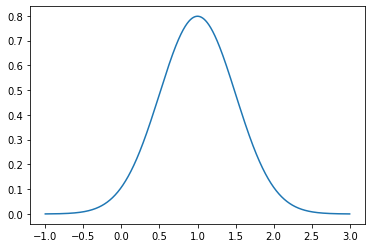

In [9]:
# prior for lambda 

fig, ax = plt.subplots()
x= np.arange(-1,3,0.001)
ax.plot(x, norm.pdf(x, loc=1, scale=0.5))

plt.show()

In [10]:
def MNL(lambda_, data):  # multinomial logit probabilities

    # compute probabilities from utility defined above
    prob_n = np.exp(lambda_*(-(np.random.normal(loc=data['duration'].values, scale=np.sqrt(data['duration'].values))*3.84 + 
                               np.random.normal(loc=data['price'].values, scale=np.sqrt(data['price'].values))) + np.random.normal(loc=0, scale=10)))
    prob_d = np.sum(prob_n)
    pred =  prob_n/prob_d
    return pred
    
def like(lambda_, obs=data['ridership'], return_prob=False):   # compute likelihood

    pred = []
    # scale = 10000**2

    # get MNL probabilities for each o-d travel modes
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
      data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):   # iterate each o-d
        odLoc = data[(data.pulocationid == o) & (data.dolocationid == d)]
        pred.append(MNL(lambda_, odLoc))

    pred = np.array(list(itertools.chain(*pred)))

    pred = pred.astype(float)
    pred[pred == 0] = 0.0001

    # return_prob argument is for getting numpy array vs tensor (required for MCMC sampling)
    if return_prob == True:
        return np.sum(np.log(pred)*obs)
    else:
        return tt.sum(tt.log(pred)*obs)

Let's estimate the posterior distribution of lambda parameter from MCMC simulations.

In [11]:
with pm.Model() as transport_model:
    lambda1 = pm.Normal('lambda', mu=1, sd=0.5) # lambda prior

    likelihood = pm.Potential('likelihood', like(lambda1.random(), data['ridership'])) ## likelihood, we call above likelihood function with 'Potential' in pymc3
    start = pm.find_MAP()  # find max likelihood
    trace = pm.sample(1000, start=start, progressbar=True) # estimate posterior from MCMC sampling

logp = -3.8037e+08, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 402.33it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda]
100%|██████████| 1500/1500 [00:00<00:00, 2158.20it/s]


<Figure size 720x720 with 0 Axes>

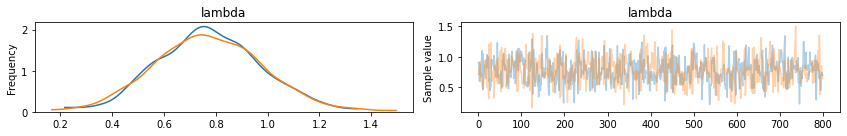

<Figure size 720x720 with 0 Axes>

In [12]:
fig = pm.traceplot(trace[199:1000])
plt.figure(figsize = (10, 10))

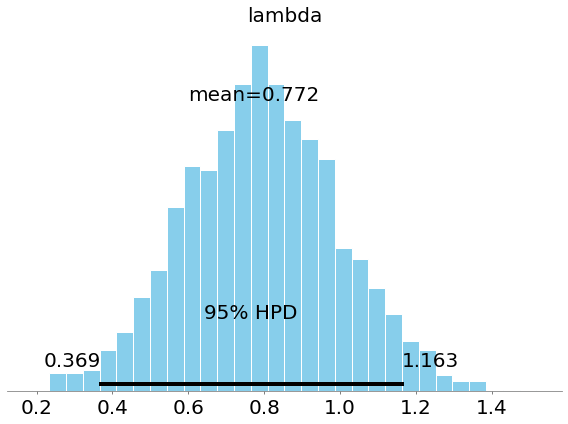

In [13]:
pm.plot_posterior(trace, figsize = (8, 6), text_size = 20);

In [14]:
# print max-likelihood lambda

print(start['lambda'])

0.77


### Assessing mode-shift in an intervention scenario

Now let's use the above model to evaluate the change in mobility across 4 modes when we impose an intervention case - additional surcharge of $3 for taxi rides anywhere in the city. One can expect a decrease in ridership for taxis owing to this intervention but assessing the mode-shift would enable to see how exactly the trips would redistribute across the other modes.

We will estimate the mode-shift numbers with respect to uncertainty by calculating the variance in trip numbers across all modes. This can be done by estimating variance of mode-shift numbers for lambdas drawn from posterior distribution, weighted by their likelihood values.

Now let's make another copy of data with the additional $3 surcharge to the taxi trips.

In [15]:
data1 = data.copy()  # make new df
data1.loc[data1.tmode == 3, 'price'] = data1.loc[data1.tmode == 3, 'price'] + 3
data1.head()

pulocationid  dolocationid  tmode  duration      price  ridership
0             3             7      8  0.653356  12.721600        736
1             3             7      3  0.798016  46.157143          0
2             3            18      3  0.254000  15.900000       1748
3             3            18      5  1.084444   0.000000       3174
4             3            18      8  0.268923   7.432000      10879

Let's run the model and estimate aggregate mode-shift across modes w.r.t. uncertainty.

In [16]:
lambdas = np.random.choice(trace['lambda'], 10)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data1[(data1.pulocationid == o) & (data1.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

In [17]:
# calculate average and std of mode-shift numbers

for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode', mode, ':', mean, ', std:', np.sqrt(std))

average change for mode 2 : 2.666840071406824 , std: 1.3889803197270518
average change for mode 3 : -44.48737254017398 , std: 5.609705449034866
average change for mode 5 : 0.572600160672161 , std: 2.331862965937152
average change for mode 8 : 3.4864252657548946 , std: 3.8455272046576012


## Custom Neural Network model for mode-choice probabilities

Let's introduce a simulation based approach for individual choice probabilities. The Multinomial logit model above is based on having closed form solutions for mode probabilites. However not depending on that allow us to have further flexibility in choosing the modeling framework. 

Here, for each o-d pair we assess utility based on travel time and cost estimates as well as a random factor, representing individual preferences towards each mode as $U = -(\beta * T*C + P) + \epsilon$, where $\beta$ is the rationality adjustment parameter for cost of time estimate (can be subject to fit), T is the travel time estimate, P is the travel fare/cost estimate and C is the adjustment for hourly income for NYC. The random error term $\epsilon$ can be chosen to be additive or multiplicative. In case of multiplicative random term, we can transform the utilities in log scale as $ln(U) = -ln(\beta * T*C + P) + \epsilon$

The mode-choice probabilities are then directly determined by the maximum utilities of 4 modes in question for a given o-d pair. 

Unlike the multinomial logit model setting, the model formulation above might not have a closed-form analytic solution for the choice probabilities. Also, doing parameter estimation through simulations might be computationally costly. In order to streamline the computational process, we implement a neural network (NN) model fitting the mode-choice probabilities between the four transportation mode as the function of their utilities with model parameters.

<img src="NN_t2.png" width="500">

We'll simulate 50,000 random utilities to fit the NN, with the simulated utilities being the input to get probabilities as the outputs. The model architecture consists of three hidden layers with 8,12,8 neurons respectively, with a rectified linear unit ("relu") activation for hidden and sigmoid for the output layer trained on 'binary cross-entropy' objective function.

Let's take the additive random term version as the utility formulation. $U = -(\beta * T*C + P) + \epsilon$, $\epsilon ~ N(0, \sigma^2)$

We can then use this trained NN model for estimating mode-choice probabilities for the LEHD mobility data (calculating the mode utilities for each o-d) instead of using simulations or explicit analytic formulas.

In [316]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from keras.losses import kullback_leibler_divergence
from keras.models import Sequential
from keras.layers import Dense
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_squared_error
from numpy import nan

import time

In [114]:
class TimeTracker(object): #time tracking
    startTime={}
    totalTime={}
    def startActivity(self,actID):
        self.startTime[actID] = time.time()
        if actID not in self.totalTime.keys():
            self.totalTime[actID] = 0
    def stopActivity(self,actID):
        self.totalTime[actID]+=time.time()-self.startTime[actID]
    def reportActivity(self,actID):
        print('Elapsed time for activity {}={}'.format(actID, self.totalTime[actID]))
    def reportTotal(self):
        for actID in self.totalTime.keys():
            self.reportActivity(actID)

TimeTrack=TimeTracker()

In [176]:
#function simulated choices probabilities
def simChoice(u, n, sigma=1, distr='normal', MNcov=None):
    #u - average utilities
    #sigma - random component std
    #n - number of simulations
    N = len(u) #number of choices
    if distr == 'normal':
        e = np.random.normal(loc=0, scale=sigma, size=(n,N))
    elif distr == 'gumbel':
        e = np.random.gumbel(loc=0, scale=sigma, size=(n,N))
    elif distr == 'multinormal':
        e = multivariate_normal.rvs(mean=np.zeros(N), cov=MNcov, size=n)

    u0 = 0
    usim = u+e #simulated utilities
    ch = np.argmax(usim, axis=1) #choices
    p = np.bincount (ch, minlength=N) #choice counts
    p = 1. * p / sum(p) #choice probabilities
    return p

#simulate sampleN random utility vectors for N modes
def randomU(N=3, sampleN=1000, sigmaU=1):
    u=np.random.normal(loc=0,scale=sigmaU,size=(sampleN,N))
    
    return u

# NN fitting
def fitNN(N=3, sampleN=1000, sigmaU=1,NNarch=[8,12,8], simSampleN=10000, epochs=300):
    u=randomU(N=N, sampleN=sampleN, sigmaU=sigmaU)

    p = np.array([simChoice(u[s,:], n=simSampleN) for s in range(sampleN)])
    print(u.shape[1], p.shape[1])

    model = Sequential()
    model.add(Dense(NNarch[0], input_dim=u.shape[1], activation='relu'))
    for l in range(1,len(NNarch)):
        model.add(Dense(NNarch[l], activation='relu'))
    model.add(Dense(p.shape[1], activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['MSE', kullback_leibler_divergence])
    model.fit(u, p, epochs=epochs, batch_size=50)
    return model

In [178]:
simSampleN=50000 #size of the simulation sample for each set of utility scores

TimeTrack.startActivity('trainNet')
model=fitNN(N=4,sampleN=10000,sigmaU=1,NNarch=5*[25],simSampleN=simSampleN)
TimeTrack.stopActivity('trainNet')
u=randomU(N=4, sampleN=1000000, sigmaU=1) #simulate 1M sets of utilities to test the model speed and out-of-sample performance
TimeTrack.startActivity('applyNet')
p=model.predict(u)  # predicted probabilities for simulated u
TimeTrack.stopActivity('applyNet')

TimeTrack.reportTotal()

4 4
Epoch 1/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4983 - MSE: 0.0302 - kullback_leibler_divergence: 0.0863
Epoch 2/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4202 - MSE: 7.8909e-04 - kullback_leibler_divergence: 3.5956e-04
Epoch 3/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4190 - MSE: 3.7632e-04 - kullback_leibler_divergence: 0.0013
Epoch 4/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4186 - MSE: 2.4381e-04 - kullback_leibler_divergence: 0.0016
Epoch 5/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4184 - MSE: 1.8519e-04 - kullback_leibler_divergence: 0.0015
Epoch 6/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4183 - MSE: 1.5575e-04 - kullback_leibler_divergence: 0.0014
Epoch 7/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4183 - MSE: 1.3278e-04 - kullback_leibler_divergence: 0.0012
Epoch 8/300
200/200 [=========

200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.1304e-05 - kullback_leibler_divergence: 9.6512e-05
Epoch 115/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.3613e-05 - kullback_leibler_divergence: 1.1107e-04
Epoch 116/300
200/200 [==============================] - 0s 2ms/step - loss: 0.4178 - MSE: 1.2011e-05 - kullback_leibler_divergence: 1.3943e-04
Epoch 117/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.2418e-05 - kullback_leibler_divergence: 7.7684e-05
Epoch 118/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.1696e-05 - kullback_leibler_divergence: 1.0190e-04
Epoch 119/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.3001e-05 - kullback_leibler_divergence: 1.0718e-04
Epoch 120/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.3153e-05 - kullback_leibler_divergence: 1.1527e-04
Epoch 

Epoch 171/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.1366e-05 - kullback_leibler_divergence: 9.1404e-05
Epoch 172/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.1304e-05 - kullback_leibler_divergence: 1.0511e-04
Epoch 173/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.1603e-05 - kullback_leibler_divergence: 9.6680e-05
Epoch 174/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.1525e-05 - kullback_leibler_divergence: 9.1267e-05
Epoch 175/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.1197e-05 - kullback_leibler_divergence: 9.2386e-05
Epoch 176/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.0327e-05 - kullback_leibler_divergence: 7.5899e-05
Epoch 177/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.0223e-05 - kullback_leibler_divergence: 1.0

Epoch 284/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.1231e-05 - kullback_leibler_divergence: 6.7076e-05
Epoch 285/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 9.3523e-06 - kullback_leibler_divergence: 1.0211e-04
Epoch 286/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 9.5650e-06 - kullback_leibler_divergence: 7.8231e-05
Epoch 287/300
200/200 [==============================] - 0s 2ms/step - loss: 0.4178 - MSE: 9.5442e-06 - kullback_leibler_divergence: 8.9841e-05
Epoch 288/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 9.2554e-06 - kullback_leibler_divergence: 6.4686e-05
Epoch 289/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 1.0171e-05 - kullback_leibler_divergence: 8.9923e-05
Epoch 290/300
200/200 [==============================] - 0s 1ms/step - loss: 0.4178 - MSE: 9.0817e-06 - kullback_leibler_divergence: 7.0

In [117]:
# lehd-acs mobility data
data = pd.read_csv('LEHD_commute.csv')
data['totalCommute'] = data.iloc[:, 5:].sum(axis=1)
data = data[['pulocationid', 'dolocationid', 'tmode', 'duration', 'price', 'totalCommute']]
data.head()

pulocationid  dolocationid  tmode   duration      price  totalCommute
0             3             7      8  39.201346  12.721600           736
1             3             7      3  47.880952  43.157143             0
2             3            18      3  15.240000  12.900000          1748
3             3            18      5  65.066667   0.000000          3174
4             3            18      8  16.135379   7.432000         10879

In [384]:
# function for getting aggregate ridership/predictions by mode based on above model
def aggMobility(data, beta=1, sigma=0.5, train=True):
    
    # train: True for getting mode numbers per o-d
    # train= False for getting aggregated mode numbers
    allMob = {2:0, 3:0, 5:0, 8:0} # dict for ridership values by mode
    
    allPredMob = []
    allU = []

    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
          data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):   # iterate each o-d

        odLoc = data[(data.pulocationid == o) & (data.dolocationid == d)]
        
        # utility function
        u = -(beta*np.random.normal(loc=odLoc['duration'].values, scale=0)*3.84 + np.random.normal(loc=odLoc['price'].values, scale=0)) + np.random.normal(loc=1, scale=sigma, size=(1,len(odLoc)))
        
        # modify utility for NN format
        u = np.pad(u[0], (0, 4-len(odLoc)))
        u[u==0] = -1000  # put utilities for missing modes as -1000
        
        mob = odLoc.totalCommute.values  # ridership
        modes = odLoc.tmode.values 
        
        pred = model.predict(u.reshape(1, -1))
        prob = pred/pred.sum(axis=1)[:,None]  # probabilities
        prob = np.nan_to_num(prob)
        predMob = prob[0][:len(mob)]*np.sum(mob)   # predicted ridership by mode for a o-d
    
#         for i, val in enumerate(predMob):
#             allMob[modes[i]] = allMob[modes[i]] + val
        
#     return allMob
        if train == False:
            for i, val in enumerate(predMob):
                allMob[modes[i]] = allMob[modes[i]] + val
                
        else:
            allPredMob.append(list(predMob))
    if train == True:
        return allPredMob
        
    else:
        return allMob

In [ ]:
# lets estimate the best parameters through a simple grid search method
# objective: minimize MSE for aggregated trips by mode
# could take ~50 mins for all samples

betas = np.linspace(0.01, 0.1, 20)
sigmas = np.linspace(0.2, 0.8, 20)

params = np.array(np.meshgrid(betas, sigmas)).T.reshape(-1, 2)

allMSE = []
for param in params:
    preds = aggMobility(data, beta=param[0], sigma=param[1], train=True)
    predFlat = [item for sublist in preds for item in sublist]
    tempD = data.copy()
    tempD['pred'] = predFlat
    tempSum = tempD.groupby(by='tmode').sum()[['pred', 'totalCommute']]
    allMSE.append(np.sqrt(mean_squared_error(tempSum.totalCommute, tempSum.pred)))
    

plt.plot(allMSE)

In [385]:
# let's calculate the % simulated mode-shift after introducing $3 surcharge for taxi trips based on best params

data1 = data.copy()  # make new df
data1.loc[data1.tmode == 3, 'price'] = data1.loc[data1.tmode == 3, 'price'] + 3
data1.head()

pre = aggMobility(data, beta=0.0905, sigma=0.33, train=False)
post = aggMobility(data1, beta=0.0905, train=False)

# predit and calculate % change
modeShift_perc = (np.array(list(post.values())) - np.array(list(pre.values())))/np.array(list(pre.values()))

{print('% change for', mode, ':', modeShift_perc[i]*100) for i, mode in enumerate([2, 3, 5, 8])}

% change for 2 : 2.5169851716000853
% change for 3 : -29.759274342406428
% change for 5 : 1.6904052869033477
% change for 8 : 4.629673124790487


{None}

The NN model predicts a change of ~30% decrease in taxi ridership